In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL


# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs
import f90nml

CUDA not available.


In [2]:
%matplotlib notebook

In [3]:
# Parameters
ABCDangle_deg = 15.0
theta = ABCDangle_deg*np.pi/180

In [4]:
# Specifying the boxes/vectors and output file
Boxesfile = 'Boxes.nml'
Boxes=f90nml.read(Boxesfile) #reads the file at a given path
Calibrationfile = 'Calibration.nml'

In [5]:
# Define boxes for calibration
nx1list=Boxes['Boxes']['nx1list']
ny1list=Boxes['Boxes']['ny1list']
labellist=Boxes['Boxes']['labellist']
boxsize=Boxes['Boxes']['boxsize']; print (boxsize)

# Packaging these values for subsequent use
nboxes = len(nx1list); print ("nboxes =", nboxes)
nx2list = np.array(nx1list)+boxsize; print(nx2list)
ny2list = np.array(ny1list)+boxsize; print(ny2list)

40
nboxes = 3
[400 315 245]
[285 125 350]


In [6]:
# Define vectors for calibration
xorigin=Boxes['Vectors']['xorigin']
yorigin=Boxes['Vectors']['yorigin']
xa=Boxes['Vectors']['xa']
ya=Boxes['Vectors']['ya']
xb=Boxes['Vectors']['xb']
yb=Boxes['Vectors']['yb']
xc=Boxes['Vectors']['xc']
yc=Boxes['Vectors']['yc']

# Packaging these values for subsequent use
linea = [xorigin,yorigin,xa,ya]; print (linea)
lineb = [xorigin,yorigin,xb,yb]
linec = [xorigin,yorigin,xc,yc]

[226, 248, 304, 388]


In [7]:
# Read the input dataset, including spacing in micrometers
imageroot = '2016-08-09_ice1_full2'
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

Filename, dx and dy SEMimages/2016-08-09_ice1_full2-D.bmp 2.280891 2.280891


<IPython.core.display.Javascript object>


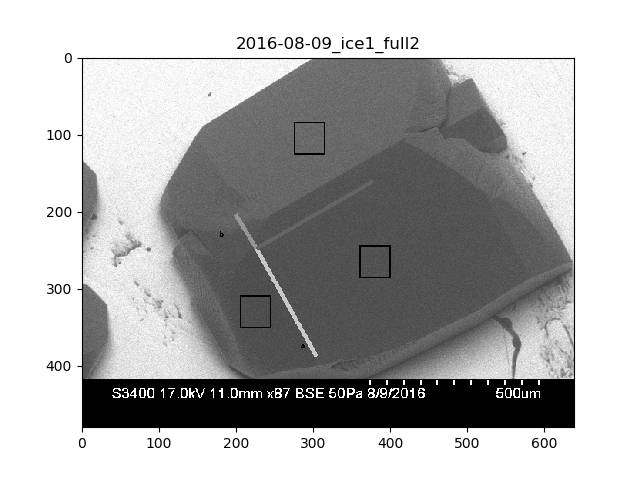

In [8]:
# Graph the segments
im = PIL.Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = PIL.ImageDraw.Draw(im)
draw.line(linea, fill=200,width=5)
draw.line(lineb, fill=150,width=5)
draw.line(linec, fill=100,width=5)
draw.text((xa-20,ya-20), 'a')
draw.text((xb-20,yb+20), 'b')   

fig, ax = plt.subplots()
for i in range(nboxes):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectanglelabel(draw,(nx1,ny1),(nx2,ny2),labellist[i])
ax.set_title(imageroot)
Iwantmicrons = False
if Iwantmicrons:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255, extent=[0,nx_im*dx,0,ny_im*dy])
    ax.set_xlabel(r'$x \ (\mu m)$',fontsize=fontsize*1.1)
    ax.set_ylabel(r'$y \ (\mu m)$',fontsize=fontsize*1.1)
else:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)


In [9]:
# Calculate normal vectors of the crystal ... Details of this will change for each crystal
avec, bvec, cvec, navec, nbvec = fbs.solveforabc(\
                 xa-xorigin,ya-yorigin,\
                 xb-xorigin,yb-yorigin,\
                 xc-xorigin,yc-yorigin)
print ('cvec =\n',cvec)
print ('unit normal a-facet =\n',navec)
print ('unit normal b-facet =\n',nbvec)

Rot28 = ims.myrotation_matrix(avec, -28.) # use avec or bvec depending on which one the pyramidal facet touches
ndvec = Rot28*navec # solverforabc gives this as already normalized 
print ('unit normal d-facet =\n',ndvec)

found 16 solutions
physically reasonable solution is # 11
cvec =
 [[ 0.86592531]
 [-0.49891061]
 [-0.03551852]]
unit normal a-facet =
 [[0.21603681]
 [0.30902278]
 [0.92619275]]
unit normal b-facet =
 [[-0.28265549]
 [-0.54669816]
 [ 0.78817954]]
unit normal d-facet =
 [[-0.21577813]
 [ 0.50707527]
 [ 0.8344546 ]]


<IPython.core.display.Javascript object>


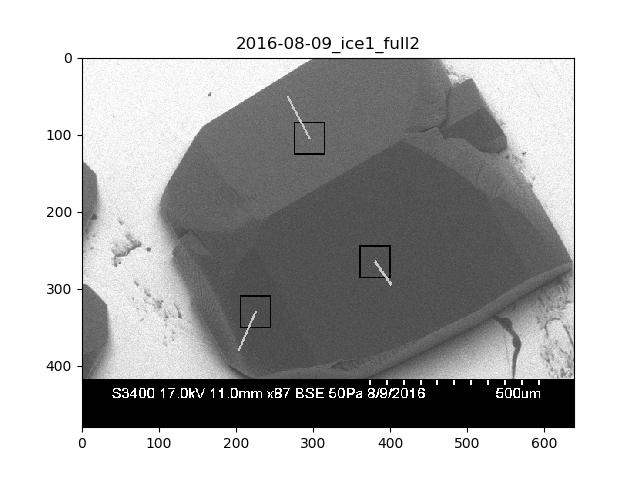

In [11]:
# This is just checking
im = PIL.Image.open(Filename)
fig, ax = plt.subplots()
draw = PIL.ImageDraw.Draw(im)
for i in range(nboxes):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectanglelabel(draw,(nx1,ny1),(nx2,ny2),labellist[i])
ax.set_title(imageroot)

# For boxes "a", "b", and "d"
amp = 100
boxcenterx = nx1list[0]+boxsize/2
boxcentery = ny1list[0]+boxsize/2
linea_disp = list(np.squeeze([boxcenterx,boxcentery,boxcenterx+navec[0]*amp,boxcentery+navec[1]*amp]).astype(int))
draw.line(linea_disp, fill=200,width=3)

boxcenterx = nx1list[1]+boxsize/2
boxcentery = ny1list[1]+boxsize/2
lineb_disp = list(np.squeeze([boxcenterx,boxcentery,boxcenterx+nbvec[0]*amp,boxcentery+nbvec[1]*amp]).astype(int))
draw.line(lineb_disp, fill=200,width=3)

boxcenterx = nx1list[2]+boxsize/2
boxcentery = ny1list[2]+boxsize/2
lineb_disp = list(np.squeeze([boxcenterx,boxcentery,boxcenterx+ndvec[0]*amp,boxcentery+ndvec[1]*amp]).astype(int))
draw.line(lineb_disp, fill=200,width=3)


ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)

In [10]:
# For each detector, get s-values
sAa, sBa, sCa, sDa = ims.mygets(navec,theta)
sAb, sBb, sCb, sDb = ims.mygets(nbvec,theta)
sAd, sBd, sCd, sDd = ims.mygets(ndvec,theta)
slistA = np.squeeze(np.array([sAa, sAb, sAd]))
slistB = np.squeeze(np.array([sBa, sBb, sBd]))
slistC = np.squeeze(np.array([sCa, sCb, sCd]))
slistD = np.squeeze(np.array([sDa, sDb, sDd]))

# For each detector, get s-values
sAa, sBa, sCa, sDa = ims.mygets(navec,theta)
sAb, sBb, sCb, sDb = ims.mygets(nbvec,theta)
sAd, sBd, sCd, sDd = ims.mygets(ndvec,theta)
slistA = np.squeeze(np.array([sAa, sAb, sAd]))
slistB = np.squeeze(np.array([sBa, sBb, sBd]))
slistC = np.squeeze(np.array([sCa, sCb, sCd]))
slistD = np.squeeze(np.array([sDa, sDb, sDd]))

# Extract the observed intensities
cA_obs = []
cB_obs = []
cC_obs = []
cD_obs = []
for isegment in range(nboxes):
    nx1=nx1list[isegment]; nx2=nx2list[isegment] 
    ny1=ny1list[isegment]; ny2=ny2list[isegment]
    cA_obs.append(np.mean(cA[ny1:ny2,nx1:nx2].astype('float')))
    cB_obs.append(np.mean(cB[ny1:ny2,nx1:nx2].astype('float')))
    cC_obs.append(np.mean(cC[ny1:ny2,nx1:nx2].astype('float')))
    cD_obs.append(np.mean(cD[ny1:ny2,nx1:nx2].astype('float')))

In [12]:
# For each detector, get s-values
sAa, sBa, sCa, sDa = ims.mygets(navec,theta)
sAb, sBb, sCb, sDb = ims.mygets(nbvec,theta)
sAd, sBd, sCd, sDd = ims.mygets(ndvec,theta)
slistA = np.squeeze(np.array([sAa, sAb, sAd]))
slistB = np.squeeze(np.array([sBa, sBb, sBd]))
slistC = np.squeeze(np.array([sCa, sCb, sCd]))
slistD = np.squeeze(np.array([sDa, sDb, sDd]))

# For each detector, get s-values
sAa, sBa, sCa, sDa = ims.mygets(navec,theta)
sAb, sBb, sCb, sDb = ims.mygets(nbvec,theta)
sAd, sBd, sCd, sDd = ims.mygets(ndvec,theta)
slistA = np.squeeze(np.array([sAa, sAb, sAd]))
slistB = np.squeeze(np.array([sBa, sBb, sBd]))
slistC = np.squeeze(np.array([sCa, sCb, sCd]))
slistD = np.squeeze(np.array([sDa, sDb, sDd]))

# Extract the observed intensities
cA_obs = []
cB_obs = []
cC_obs = []
cD_obs = []
for isegment in range(nboxes):
    nx1=nx1list[isegment]; nx2=nx2list[isegment] 
    ny1=ny1list[isegment]; ny2=ny2list[isegment]
    cA_obs.append(np.mean(cA[ny1:ny2,nx1:nx2].astype('float')))
    cB_obs.append(np.mean(cB[ny1:ny2,nx1:nx2].astype('float')))
    cC_obs.append(np.mean(cC[ny1:ny2,nx1:nx2].astype('float')))
    cD_obs.append(np.mean(cD[ny1:ny2,nx1:nx2].astype('float')))


<IPython.core.display.Javascript object>


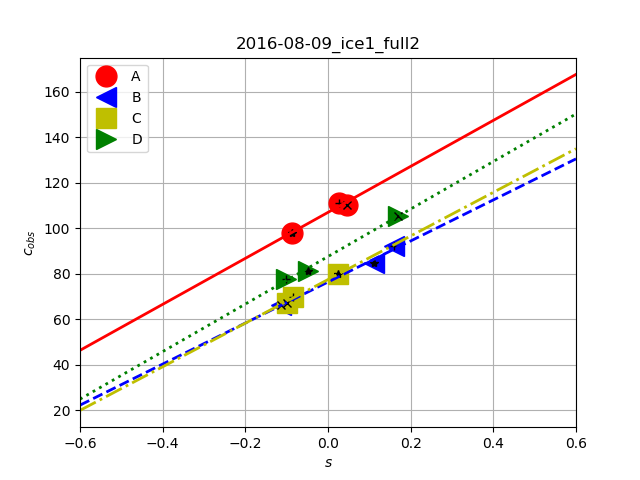

pA = 101.04798753005787 , 106.95887317721639
pB = 90.18237779372573 , 76.35614831808013
pC = 95.82443303361673 , 77.43159965024363
pD = 104.42973142352436 , 87.54914609117085


Text(0.5,1,'2016-08-09_ice1_full2')

In [13]:
# See what the A-D detector parameters look like graphically
plt.figure()
markersize = 10
plt.plot(slistA,cA_obs,'or',markersize=15)
plt.plot(slistB,cB_obs,'<b',markersize=15)
plt.plot(slistC,cC_obs,'sy',markersize=15)
plt.plot(slistD,cD_obs,'>g',markersize=15)
plt.legend(['A', 'B', 'C', 'D'],loc='upper left')
plt.plot(slistA[0],cA_obs[0],'k*')
plt.plot(slistA[1],cA_obs[1],'kx')
plt.plot(slistA[2],cA_obs[2],'k+')
plt.plot(slistB[0],cB_obs[0],'k*')
plt.plot(slistB[1],cB_obs[1],'kx')
plt.plot(slistB[2],cB_obs[2],'k+')
plt.plot(slistC[0],cC_obs[0],'k*')
plt.plot(slistC[1],cC_obs[1],'kx')
plt.plot(slistC[2],cC_obs[2],'k+')
plt.plot(slistD[0],cD_obs[0],'k*')
plt.plot(slistD[1],cD_obs[1],'kx')
plt.plot(slistD[2],cD_obs[2],'k+')
plt.grid()
srange = [-.6,.6]
plt.xlim(srange)
plt.xlabel('$s$')
plt.ylabel('$c_{obs}$')


# Fitting
maxorder = 1
order = min(len(slistA)-1,maxorder)
pA = np.polyfit(slistA,cA_obs,order); print('pA =', pA[0], ',', pA[1])
pB = np.polyfit(slistB,cB_obs,order); print('pB =', pB[0], ',', pB[1])
pC = np.polyfit(slistC,cC_obs,order); print('pC =', pC[0], ',', pC[1])
pD = np.polyfit(slistD,cD_obs,order); print('pD =', pD[0], ',', pD[1])
s_theory = np.linspace(srange[0],srange[1])
cA_theory = np.polyval(pA,s_theory)
cB_theory = np.polyval(pB,s_theory)
cC_theory = np.polyval(pC,s_theory)
cD_theory = np.polyval(pD,s_theory)
plt.plot(s_theory,cA_theory,'-r',linewidth=2)
plt.plot(s_theory,cB_theory,'--b',linewidth=2)
plt.plot(s_theory,cC_theory,'-.y',linewidth=2)
plt.plot(s_theory,cD_theory,':g',linewidth=2)
plt.title(imageroot)

In [14]:
# Save the calibration file
cfile = open(Calibrationfile,'w')
cfile.write('&Calibration\n')
cfile.write('   '+'pA = '+str(pA[0])+',  '+str(pA[1])+'\n')
cfile.write('   '+'pB = '+str(pB[0])+',  '+str(pB[1])+'\n')
cfile.write('   '+'pC = '+str(pC[0])+',  '+str(pC[1])+'\n')
cfile.write('   '+'pD = '+str(pD[0])+',  '+str(pD[1])+'\n')
cfile.write('/ \n')
cfile.close()